In [13]:
import sys
sys.path.insert(0, '../')

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from typing import Tuple
from pickle import load, dump
from glob import glob
from sklearn.model_selection import train_test_split
from typing import Tuple
from src.vg2signal import read_raw_vg_as_df, make_smoother, make_shoulder_getter, make_detilter

In [34]:
def v2signal_extra_features(vg_filename: str,
             do_log: bool,
             smoothing_bw: float,
             vcenter: float,
             vwidth: float,
             stiffness: float):

    vg_df = read_raw_vg_as_df(vg_filename)

    if (vg_df['I'].to_numpy() < 0).any():
        temp = [None] * 11
        return [None, None, vg_df] + temp

    if do_log:
        cur_var_name = "logI"
        #vg_df[cur_var_name] = np.emath.logn(logbase, vg_df["I"])
        vg_df[cur_var_name] = np.log2(vg_df["I"])
    else:
        cur_var_name = "I"

    smoother = make_smoother(smoothing_bw)

    vg_df["smoothed"] = smoother(vg_df["V"], vg_df[cur_var_name].to_numpy())

    shoulder_getter = make_shoulder_getter(1, 1.1)
    (peak_signal, peak_v_shoulder) = shoulder_getter(vg_df["V"],
                                                     vg_df["smoothed"])

    vcenter = peak_v_shoulder
    vstart = vcenter - 0.5*vwidth
    vend = vcenter + 0.5*vwidth

    detilter = make_detilter(vstart, vend, stiffness)
    vg_df["detilted"] = detilter(vg_df["V"].to_numpy(),
                                 vg_df["smoothed"].to_numpy())

   
    return  vg_df

def run_vg2_raw(folderpath: str, 
            do_log:bool, 
            recenter:bool, 
            smoothing_bw:float, 
            stiffness:float, 
            vcenter:float, 
            vwidth1:float, 
            vwidth2:float) -> Tuple[dict, str]:

    os.chdir(folderpath)  # change to desired folderpath
    dfxl     = pd.DataFrame(columns=['labels', 'VI'])
    
    for filename in os.listdir():
        if filename[-3:] == 'txt':
            print("Analyzing:", filename)
            df = v2signal_extra_features(filename,
                                        do_log,
                                        smoothing_bw,
                                        vcenter,
                                        vwidth1,
                                        stiffness)

            idx1 = filename.rfind("cbz")
            idx2 = filename[idx1:].find("_")
            conc = filename[idx1 + 3:idx1 + idx2]
            replicate = filename[idx1 + idx2 + 1:filename.rfind(".")]

            # Crop only the signal
            try:
                crop = (df['V']<1.15) & (df['V']>0.93)
                VI   =  df['detilted'][crop].to_numpy() 
            except:
                continue

            if 'p' in conc:  
                pi = conc.find('p')
                conctemp = conc[:pi] + '.' + conc[pi + 1:]
                conc = conctemp
            
            concstrxl   = str(float(conc))
            dfxl = pd.concat([dfxl, pd.DataFrame({'labels':concstrxl, 'VI':[VI]})])

    with open(f"{folderpath}/raw_data.pickle", 'wb') as f:
        dump(dfxl, f)
   
    return    dfxl  

def load_dataset(dataset_path=None) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    if dataset_path==None: dataset_path = DATASET_PATH

    if ('ML1_ML2'in os.path.basename(dataset_path)) or ('test' in os.path.basename(dataset_path)):
        datasets = sorted([f"{i}/raw_data.pickle" for i in glob(f'{dataset_path}/*')])
        
        df = []
        for dataset in datasets:

            with open(dataset, 'rb') as f:
                data = load(f)
                df.append(data) 
        df = pd.concat(df)

    else:
        dataset_path = f"{dataset_path}/raw_data.pickle"
        with open(dataset_path, 'rb') as f:
            df = load(f)

    X = [x.iloc[0] for (_,x) in df[['VI']].iterrows()] 
    X = np.array(X)
    y = df['labels'].apply(lambda x: float(x))

    # Split the total dataset into training (60%) and testing (40%) dataset
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=20, stratify=y)

    return (X_train, X_test, y_train, y_test), (X, y)

In [35]:
(ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1')
(ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2')
(ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4')

0.0


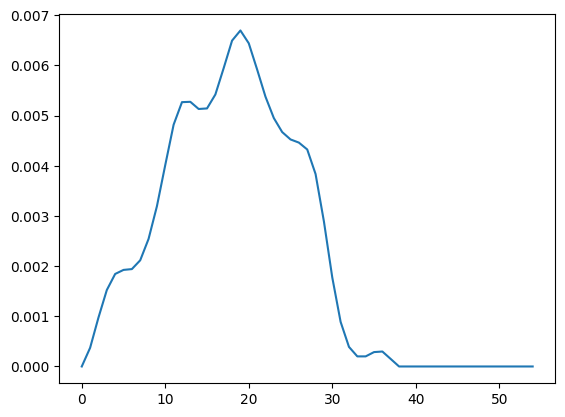

In [37]:
indx = 0

plt.plot(ML1_X_train[indx])
print(ML1_y_train.iloc[indx])


In [48]:
only_blank_ML1 = ML1_X_train[ML1_y_train==0]
avg_peak       = np.median([i.max() for i in only_blank_ML1])
avg_peak

0.008321516177054233

16.0


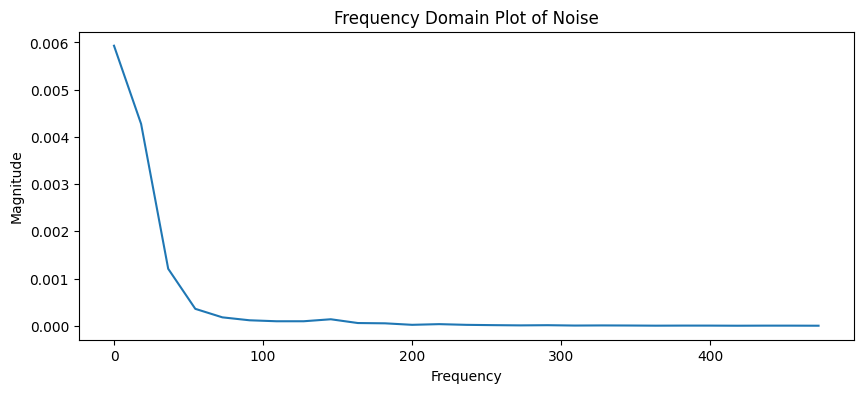

In [71]:
from scipy.fftpack import fft

ind = 16
print(ML1_y_train.iloc[ind])
noise_data = only_blank_ML1[ind]

# Perform FFT
N = len(noise_data)
T = 1.0 / 1000.0  # Sample spacing (assumed for this example)
yf = fft(noise_data)
xf = np.fft.fftfreq(N, T)[:N//2]

# Plotting frequency domain representation
plt.figure(figsize=(10, 4))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title("Frequency Domain Plot of Noise")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [45]:
only_blank = ML2_X_train[ML2_y_train==0]
avg_peak   = np.median([i.max() for i in only_blank])
avg_peak

0.009213955689310604

In [46]:
only_blank = ML4_X_train[ML4_y_train==0]
avg_peak   = np.median([i.max() for i in only_blank])
avg_peak

0.006156196025582705